# 1. Dataset Preparation

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch.utils.data import TensorDataset

# Load data
train_df = pd.read_csv("https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv", sep="\t", header=0)
train_df.columns = ['sentence', 'label']
test_df = pd.read_csv("https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv", sep="\t", header=0)
test_df.columns = ['sentence', 'label']


# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train_full = vectorizer.fit_transform(train_df['sentence']).toarray()
y_train_full = train_df['label'].values

X_test = vectorizer.transform(test_df['sentence']).toarray()

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Convert to tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train))
val_dataset   = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val))
test_dataset  = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.zeros(len(X_test), dtype=torch.long))



In [40]:
train_dataset.tensors[0].shape, test_dataset.tensors[0].shape, val_dataset.tensors[0].shape

(torch.Size([5535, 10000]),
 torch.Size([1820, 10000]),
 torch.Size([1384, 10000]))

In [ ]:
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(train_df['a stirring '])
val_dataset = TextDataset(val_df, vectorizer)

train_dataset = TextDataset(train_df, vectorizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 2. Construct a Multi-Layer Perceptron (MLP) model

In [6]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, output_dim, dropout=0.3):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [ ]:
# Initialize model
model = MLP(input_dim=10000, hidden_sizes=[512, 256, 128, 64], output_dim=2)
print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable Parameters:", count_parameters(model))

Trainable Parameters: 5293122


# 3. Training the model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to device
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training config
num_epochs = 10
best_val_acc = 0.0
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    preds, labels = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
            preds += outputs.argmax(dim=1).cpu().tolist()
            labels += yb.cpu().tolist()

    acc = accuracy_score(labels, preds)
    epoch_train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    train_losses.append(epoch_train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc*100:.2f}%")

    # Save best model
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model, "checkpoint.pt")


Using device: cuda
Epoch 1/10 | Train Loss: 0.6288 | Val Loss: 0.4642 | Val Acc: 77.10%
Epoch 2/10 | Train Loss: 0.2825 | Val Loss: 0.5231 | Val Acc: 77.75%
Epoch 3/10 | Train Loss: 0.0956 | Val Loss: 0.7321 | Val Acc: 78.03%
Epoch 4/10 | Train Loss: 0.0246 | Val Loss: 1.0851 | Val Acc: 77.46%
Epoch 5/10 | Train Loss: 0.0057 | Val Loss: 1.3985 | Val Acc: 77.89%
Epoch 6/10 | Train Loss: 0.0017 | Val Loss: 1.7790 | Val Acc: 78.32%
Epoch 7/10 | Train Loss: 0.0013 | Val Loss: 1.7990 | Val Acc: 77.82%
Epoch 8/10 | Train Loss: 0.0001 | Val Loss: 2.1245 | Val Acc: 78.25%
Epoch 9/10 | Train Loss: 0.0002 | Val Loss: 2.2472 | Val Acc: 77.82%
Epoch 10/10 | Train Loss: 0.0003 | Val Loss: 2.3581 | Val Acc: 78.11%


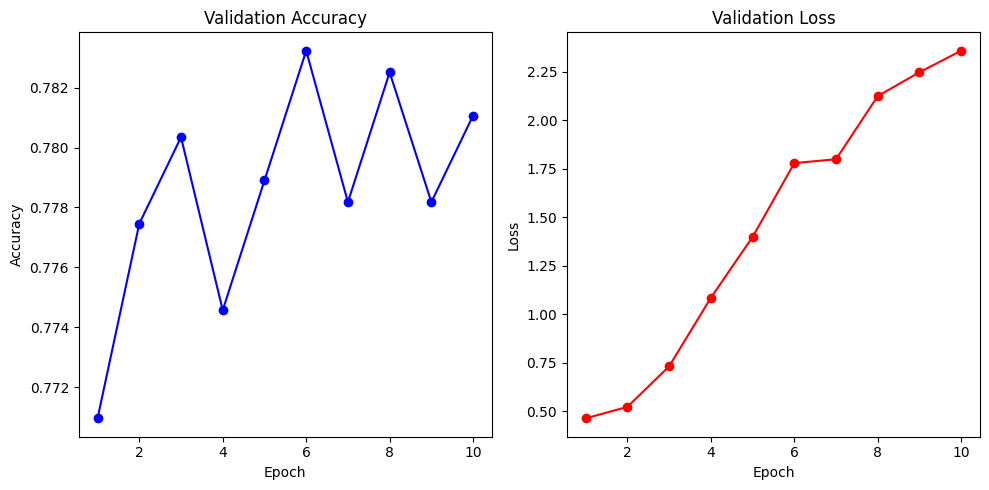

In [10]:
# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), val_accuracies, marker='o', color='b')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_losses, marker='o', color='r')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()


# 4. Quantization

## Dynamic Quantization with INT4 or INT8

In [27]:
import torch
import torch.quantization as tq

model = torch.load("checkpoint.pt", weights_only=False)


# Apply dynamic quantization (use INT8)
model_dynamic = tq.quantize_dynamic(
    model,  # Original model
    {nn.Linear},  # Apply quantization to linear layers only
    dtype=torch.qint8  # Use INT8 quantization
)

# Optionally,  apply INT4 
# model_dynamic = tq.quantize_dynamic(
#     model, 
#     {nn.Linear},
#     dtype=torch.qint4  # Use INT4 quantization
# )

# Verify the quantized model architecture
print(model_dynamic)

# Save the quantized model if needed
torch.save(model_dynamic, "quantized_model_int8.pt")


MLP(
  (net): Sequential(
    (0): DynamicQuantizedLinear(in_features=10000, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): DynamicQuantizedLinear(in_features=512, out_features=256, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): DynamicQuantizedLinear(in_features=256, out_features=128, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): DynamicQuantizedLinear(in_features=128, out_features=64, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): DynamicQuantizedLinear(in_features=64, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  )
)


## Half precision 

In [12]:
# Convert the model to half precision (FP16)
model = torch.load("checkpoint.pt", weights_only=False)
model_half = model.half()

# Verify the model is now in half precision
print(model_half)

# Save the model in half precision
torch.save(model_half, "half_precision_model.pt")


MLP(
  (net): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=2, bias=True)
  )
)


# 5. Results

In [13]:
from torch.utils.data import TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn as nn
import pandas as pd
import torch

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, output_dim, dropout=0.3):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

BATCH_SIZE=64
# def quick_get_val_loader(BATCH_SIZE=64):
# Load data
train_df = pd.read_csv("https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv", sep="\t", header=0)
train_df.columns = ['sentence', 'label']

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train_full = vectorizer.fit_transform(train_df['sentence']).toarray()
y_train_full = train_df['label'].values

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Convert to tensors
val_dataset   = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val))
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print("Done loading data")
# return val_loader

# val_loader = quick_get_val_loader(BATCH_SIZE=64)

Done loading data


In [ ]:
import torch
import pandas as pd
import time
import os

def get_model_size_mb(path):
    size_bytes = os.path.getsize(path)
    size_mb = size_bytes / (1024 * 1024)
    return round(size_mb, 2)


def evaluate_model(model, loader, model_type="original"):
    model.eval().cpu()
    
    # Handle half-precision model
    if model_type == "half":
        model = model.half()

    correct, total = 0, 0
    total_time = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.cpu()
            yb = yb.cpu()

            if model_type == "half":
                xb = xb.half()
            elif model_type == "quantized":
                # dynamic quantized models usually accept float32 input (quantization happens inside)
                xb = xb.float()

            start = time.time()
            out = model(xb)
            end = time.time()

            pred = out.argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
            total_time += (end - start)

    acc = 100 * correct / total
    avg_time = (total_time * 1000) / total  # ms/sample
    return acc, avg_time


# Model architecture params
input_dim = 10000
hidden_sizes = [512, 256, 128, 64]
output_dim = 2

# Initialize and load original model
model = torch.load("checkpoint.pt", weights_only=False, map_location="cpu")

# Initialize and load quantized model (must stay on CPU)
model_dynamic = torch.load("quantized_model_int8.pt", weights_only=False, map_location="cpu")

# Initialize and load half precision model
model_half = MLP(input_dim, hidden_sizes, output_dim).half()  # half precision
model_half = torch.load("half_precision_model.pt", weights_only=False, map_location="cpu")

print("Models loaded")


acc_orig, time_orig = evaluate_model(model, val_loader, model_type="original")
acc_quant, time_quant = evaluate_model(model_dynamic, val_loader, model_type="quantized")
acc_half, time_half = evaluate_model(model_half, val_loader, model_type="half")

# Create a DataFrame structure
results_df = pd.DataFrame({
    "S.I.": [1, 2, 3],
    "Model Name": ["Original", "Dynamic", "Half"],
    "Accuracy (Out of 100)": [acc_orig, acc_quant, acc_half],
    "Storage (In MB)": [get_model_size_mb("checkpoint.pt"), get_model_size_mb("quantized_model_int8.pt"), get_model_size_mb("half_precision_model.pt")],
    "Inference time (In ms)": [time_orig, time_quant, time_half]
})

# Display the table
results_df


Models loaded


,S.I.,Model Name,Accuracy (Out of 100),Storage (In MB),Inference time (In ms)
0,1,Original,78.323699,20.20,0.091773
1,2,Dynamic,78.106936,5.06,0.038578
2,3,Half,78.323699,10.10,4.528409
